# FastPitch Training on German dataset (Characters and phonemes)

This notebook is designed to provide a guide on how to train FastPitch on German dataset from scratch as part of the TTS pipeline. It contains the following sections:
  1. **Introduction**: FastPitch and HiFi-GAN in NeMo
  2. **Preprocessing**: How to prepare German dataset for FastPitch
  3. **Training**: Example of FastPitch training and evaluation
  4. **Finetuning HiFi-GAN**: Improving speech quality by Finetuning HiFi-GAN on synthesized mel-spectrograms from Fastpitch

# License

> Copyright 2022 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [1]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies# .
"""
BRANCH = 'main'
# # If you're using Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget unidecode pynini==2.1.4 scipy==1.7.3
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

In [2]:
import json
import nemo
import torch
import librosa
import numpy as np

from pathlib import Path
from tqdm.notebook import tqdm

# Introduction

### FastPitch

FastPitch is non-autoregressive model for mel-spectrogram generation based on FastSpeech, conditioned on fundamental frequency contours. For more details about model, please refer to the original [paper](https://arxiv.org/abs/2006.06873). NeMo re-implementation of FastPitch additionally uses unsupervised speech-text [aligner](https://arxiv.org/abs/2108.10447) which was originally implemented in [FastPitch 1.1](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/FastPitch).

### HiFiGAN
HiFiGAN is a generative adversarial network (GAN) model that generates audio from mel spectrograms. The generator uses transposed convolutions to upsample mel spectrograms to audio. For more details about the model, please refer to the original [paper](https://arxiv.org/abs/2010.05646). NeMo re-implementation of HiFi-GAN can be found [here](https://github.com/NVIDIA/NeMo/blob/main/nemo/collections/tts/models/hifigan.py).


In [10]:
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder
from nemo.collections.tts.models import FastPitchModel, HifiGanModel

from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import IPython.display as ipd
%matplotlib inline

In [4]:
# Let's see what pretrained models are available for FastPitch and Mixer-TTS
print("FastPitch pretrained models:")
print(FastPitchModel.list_available_models())
print("=====================================")
print("HiFi-GAN pretrained models:")
print(HifiGanModel.list_available_models())

FastPitch pretrained models:
[PretrainedModelInfo(
	pretrained_model_name=tts_en_fastpitch,
	description=This model is trained on LJSpeech sampled at 22050Hz with and can be used to generate female English voices with an American accent.,
	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/1.8.1/files/tts_en_fastpitch_align.nemo,
	class_=<class 'nemo.collections.tts.models.fastpitch.FastPitchModel'>
)]
HiFi-GAN pretrained models:
[PretrainedModelInfo(
	pretrained_model_name=tts_hifigan,
	description=This model is trained on LJSpeech audio sampled at 22050Hz and mel spectrograms generated from Tacotron2, TalkNet, and FastPitch. This model has been tested on generating female English voices with an American accent.,
	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo,
	class_=<class 'nemo.collections.tts.models.hifigan.HifiGanModel'>
), PretrainedModelInfo(
	pretrained_model_name=tts_en_lj_hifiga

In [5]:
# We can load the pre-trained Fastpitch model as follows
pretrained_model = "tts_en_fastpitch"
spec_gen = FastPitchModel.from_pretrained(pretrained_model)
spec_gen.eval();

[NeMo I 2022-05-25 18:15:04 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/1.8.1/files/tts_en_fastpitch_align.nemo to /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo
100% [......................................................................] 187023360 / 187023360[NeMo I 2022-05-25 18:15:19 common:747] Instantiating model from pre-trained checkpoint
[NeMo I 2022-05-25 18:15:19 tokenize_and_classify:93] Creating ClassifyFst grammars.


[NeMo W 2022-05-25 18:15:37 g2ps:84] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-05-25 18:15:37 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
      sample_rate: 22050
      sup_data_path: /raid/LJSpeech/supplementary
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: nu

[NeMo I 2022-05-25 18:15:37 features:259] PADDING: 1
[NeMo I 2022-05-25 18:15:37 features:276] STFT using torch
[NeMo I 2022-05-25 18:15:40 save_restore_connector:209] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo.


In [6]:
# In the same way, we can load the pre-trained HiFi-GAN model as follows
pretrained_model = "tts_hifigan"
vocoder = HifiGanModel.from_pretrained(pretrained_model)
vocoder.eval();

[NeMo I 2022-05-25 18:15:40 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-05-25 18:15:40 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-05-25 18:15:40 common:747] Instantiating model from pre-trained checkpoint


[NeMo W 2022-05-25 18:15:42 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-05-25 18:15:42 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-05-25 18:15:42 features:259] PADDING: 0
[NeMo I 2022-05-25 18:15:42 features:276] STFT using torch


[NeMo W 2022-05-25 18:15:42 features:233] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-05-25 18:15:42 features:259] PADDING: 0
[NeMo I 2022-05-25 18:15:42 features:276] STFT using torch
[NeMo I 2022-05-25 18:15:43 save_restore_connector:209] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.9.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


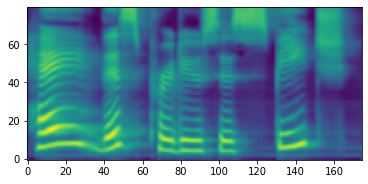

In [16]:
assert isinstance(spec_gen, SpectrogramGenerator)
assert isinstance(vocoder, Vocoder)

with torch.no_grad():
    parsed = spec_gen.parse("Hey, this produces speech!", normalize=True)
    spectrogram = spec_gen.generate_spectrogram(tokens=parsed)
    audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)

# Now we can visualize the generated spectrogram
# If we want to generate speech, we have to use a vocoder in conjunction to a spectrogram generator.
# Refer to the Inference_ModelSelect notebook on how to convert spectrograms to speech.
imshow(spectrogram.cpu().detach().numpy()[0,...], origin="lower")
plt.show()

In [17]:
audio = audio.to('cpu').numpy()[0]
audio = audio / np.abs(audio).max()
ipd.display(ipd.Audio(audio, rate=22050))

# Preprocessing

In [ ]:
# imports

We will show example of preprocessing and training using OpenSLR's German Neutral TTS dataset ([link](https://www.openslr.org/95)). It is a free single german speaker dataset (> 23 hours) by Thorsten Müller (voice) and Dominik Kreutz (audio optimization) for tts training. 

In this section, we will cover:
1. Downloading the dataset
2. Creating Manifests & Normalizing Text
3. Augmenting dataset with phonemes
4. Create dataset config
5. Create suppplementary data

## 1. Downloading the dataset 

```bash
mkdir /Data && cd /Data
wget https://us.openslr.org/resources/95/thorsten-de_v02.tgz
tar -zxvf thorsten-de_v02.tgz
```

`/Data` directory looks like:
```bash
$ ls /Data -R
/Data:
thorsten-de
thorsten-de_v02.tgz

/Data/thorsten-de:
metadata.csv
metadata_shuf.csv
metadata_train.csv
metadata_val.csv
wavs

/Data/thorsten-de/wavs:
00025a6fbea659dae6ece011e749aa34.wav
000314280388fb390b3e70b69ee53a23.wav
000624f768d7e282534a850980619fb2.wav
...
```

## 2. Creating Manifests & Normalizing Text

`get_data.py` reads the `metadata.csv` provided with the dataset and generates 4 fields for each datapoint:
1. `audio_filepath`: location of the wav file
2. `duration`: duration of the wav file
3. `text`: original text supplied by OpenSLR
4. `normalized_text`: normalized text via NeMo's text normalizer 
    ```python
    nemo_text_processing.text_normalization.normalize.Normalizer(lang="de", input_case="cased", overwrite_cache=True, cache_dir=str(file_path / "cache_dir"))
    ```
    
Example record:
```json
{"audio_filepath": "/github/datasets/openslr-95-german-neutral-tts/thorsten-de/wavs/e50eb02c25353f85549900d2fc1e0e32.wav", "duration": 2.409977, "text": "Geht die Schandtat auf sein Konto?", "normalized_text": "Geht die Schandtat auf sein Konto?"}
```
After that, the script randomly splits the datapoints into 3 buckets, `train_manifest.json`, `val_manifest.json` and `test_manifest.json`.

```bash

cd /NeMo
python scripts/dataset_processing/tts/openslr/get_data.py --data-root /Data/ --val-size 0.1 --test-size 0.2

```

In the example above, 10% datapoints go to validation set, 20% go to test set and the remaining 70% go to training set.

`/Data` directory looks like:
```bash
$ ls /Data -R
/Data:
thorsten-de
thorsten-de_v02.tgz

/Data/thorsten-de:
metadata.csv
metadata_shuf.csv
metadata_train.csv
metadata_val.csv
test_manifest.json
train_manifest.json
val_manifest.json
wavs

/Data/thorsten-de/wavs:
00025a6fbea659dae6ece011e749aa34.wav
000314280388fb390b3e70b69ee53a23.wav
000624f768d7e282534a850980619fb2.wav
...
```

## 3. Augmenting dataset with phonemes

The original dataset only contains text input, however we want our model to be able to accept both text and phonemes. So, we need to convert our text into phonemes. We will be using [bootphon/phonemizer](https://github.com/bootphon/phonemizer) from GitHub to convert German text to phonemes. Example: 

In [29]:
print("text: Geht die Schandtat auf sein Konto?")
print("phoneme: \u0261e\u02d0t di\u02d0 \u0283ant\u0251\u02d0t a\u028af za\u026an k\u0254nto\u02d0")

text: Geht die Schandtat auf sein Konto?
phoneme: ɡeːt diː ʃantɑːt aʊf zaɪn kɔntoː



The quickest way to get started with phonemizer is to use docker container:
```bash
git clone https://github.com/bootphon/phonemizer
cd phonemizer
docker build -t phonemizer .
docker run --rm -d -it -p 8888:8888 -v /Data:/Data --ipc=host phonemizer /bin/bash
docker exec -it <docker_container_id> /bin/bash
pip install jupyterlab
jupyter lab --ip=0.0.0.0 --allow-root --NotebookApp.token='' --notebook-dir=/ --NotebookApp.allow_origin='*' &
```

Within the container, run the following python script:

```python
from phonemizer.backend import EspeakBackend
import json

backend = EspeakBackend('de')

input_manifest_filepath = "/Data/thorsten-de/train_manifest.json"
output_manifest_filepath = "/Data/thorsten-de/train_phonemes_manifest.json"

records = []
n_text = []
with open(input_manifest_filepath, "r") as f:
    for i, line in enumerate(f):
        d = json.loads(line)
        records.append(d)
        n_text.append(d['normalized_text'])

phonemized = backend.phonemize(n_text)

new_records = []
for i in range(len(records)):
    records[i]["phoneme"] = 0
    new_records.append(records[i])
    phoneme_record = records[i].copy()
    phoneme_record["normalized_text"] = phonemized[i]
    phoneme_record["phoneme"] = 1
    new_records.append(phoneme_record)
    
with open(output_manifest_filepath, "w") as f:
    for r in new_records:
        f.write(json.dumps(r) + '\n')
```

To better understand the phonemize method, refer to the docs [here](https://github.com/bootphon/phonemizer/blob/master/phonemizer/backend/base.py#L137).

Run the above script for train, test and val records, resulting in `train_phonemes_manifest.json`, `test_phonemes_manifest.json` and `val_phonemes_manifest.json` respectively.

We are effectively doublng the size of our dataset. Each original record maps on to two records, one with original `normalized_text` field value and `phonemes` set to 0 and another with phonemized text and `phonemes` flag set to 1.

Example of input record:
```json
{"audio_filepath": "/Data/thorsten-de/wavs/e50eb02c25353f85549900d2fc1e0e32.wav", "duration": 2.409977, "text": "Geht die Schandtat auf sein Konto?", "normalized_text": "Geht die Schandtat auf sein Konto?"}
```
And corresponding output records:
```json
{"audio_filepath": "/Data/thorsten-de/wavs/e50eb02c25353f85549900d2fc1e0e32.wav", "duration": 2.409977, "text": "Geht die Schandtat auf sein Konto?", "normalized_text": "Geht die Schandtat auf sein Konto?", "phoneme": 0}
{"audio_filepath": "/Data/thorsten-de/wavs/e50eb02c25353f85549900d2fc1e0e32.wav", "duration": 2.409977, "text": "Geht die Schandtat auf sein Konto?", "normalized_text": "\u0261e\u02d0t di\u02d0 \u0283ant\u0251\u02d0t a\u028af za\u026an k\u0254nto\u02d0 ", "phoneme": 1}
```


## 4. Create dataset config

Most of the configuration remains the same as described in [FastPitch_MixerTTS_Training.ipynb](FastPitch_MixerTTS_Training.ipynb) except:
1. The `text_tokenizer._target_` is set to `nemo.collections.tts.torch.tts_tokenizers.GermanCharsTokenizer` class, and pass `phonemes: true`, which will extend the `de_alphabet` to include IPA symbols, resulting in `abcdefghijklmnopqrstuvwxyzäöüßʊʃŋɜːɛɾəɪçɔøɡœɑÜ„1Q̃ɒʒÄɹÖʌθàó̈ðéɐá`.

2. The `text_normalizer.lang` is set to `de`

Final config looks like:

```yaml
name: "ds_for_fastpitch_align"

manifest_filepath: "train_manifest.json"
sup_data_path: "sup_data"
sup_data_types: [ "align_prior_matrix", "pitch" ]
whitelist_path: "nemo_text_processing/text_normalization/de/data/whitelist.tsv"

dataset:
  _target_: nemo.collections.tts.torch.data.TTSDataset
  manifest_filepath: ${manifest_filepath}
  sample_rate: 22050
  sup_data_path: ${sup_data_path}
  sup_data_types: ${sup_data_types}
  n_fft: 1024
  win_length: 1024
  hop_length: 256
  window: "hann"
  n_mels: 80
  lowfreq: 0
  highfreq: 8000
  max_duration: null
  min_duration: 0.1
  ignore_file: null
  trim: false
  pitch_fmin: 65.40639132514966
  pitch_fmax: 2093.004522404789

  text_normalizer:
    _target_: nemo_text_processing.text_normalization.normalize.Normalizer
    lang: de
    input_case: cased
    whitelist: ${whitelist_path}

  text_normalizer_call_kwargs:
    verbose: false
    punct_pre_process: true
    punct_post_process: true

  text_tokenizer:
    _target_: nemo.collections.tts.torch.tts_tokenizers.GermanCharsTokenizer
    punct: true
    apostrophe: true
    pad_with_space: true
    phonemes: true
```

## 5. Create Supplementary Data

As mentioned in the [FastPitch_MixerTTS_Training.ipynb](FastPitch_MixerTTS_Training.ipynb) - To accelerate and stabilize our training, we also need to extract pitch for every audio, estimate pitch statistics (mean and std) and pre-calculate alignment prior matrices for alignment framework. To do this, all we need to do is iterate over our data one time, via `extract_sup_data.py` script.


Example:
```bash
python scripts/dataset_processing/tts/extract_sup_data.py --config-path openslr/ds_conf --config-name ds_for_fastpitch_align.yaml manifest_filepath=/Data/thorsten-de/train_phonemes_manifest.json sup_data_path=/Data/thorsten-de/phonemes/
```

The above example gives the following result
1. Creates two folders under `sup_data_path` - `pitch` and `align_prior_matrix`
2. prints out `PITCH_MEAN, PITCH_STD = 132.524658203125, 37.389366149902344`

# Training

Before we train our model, let's define model config:

```yaml
name: FastPitch

train_dataset: ???
validation_datasets: ???
sup_data_path: ???
sup_data_types: [ "align_prior_matrix", "pitch" ]
exp_dir_var: ???

# Default values from librosa.pyin
pitch_fmin: 65.40639132514966
pitch_fmax: 2093.004522404789

# openslr/95
pitch_mean: 132.524658203125
pitch_std: 37.389366149902344

# Default values for dataset with sample_rate=44100
sample_rate: 22050
n_mel_channels: 80
n_window_size: 1024
n_window_stride: 256
n_fft: 1024
lowfreq: 0
highfreq: 8000
window: hann

whitelist_path: "nemo_text_processing/text_normalization/de/data/whitelist.tsv"

model:
  learn_alignment: true
  bin_loss_warmup_epochs: 100

  n_speakers: 1
  max_token_duration: 75
  symbols_embedding_dim: 384
  pitch_embedding_kernel_size: 3

  pitch_fmin: ${pitch_fmin}
  pitch_fmax: ${pitch_fmax}

  pitch_mean: ${pitch_mean}
  pitch_std: ${pitch_std}

  sample_rate: ${sample_rate}
  n_mel_channels: ${n_mel_channels}
  n_window_size: ${n_window_size}
  n_window_stride: ${n_window_stride}
  n_fft: ${n_fft}
  lowfreq: ${lowfreq}
  highfreq: ${highfreq}
  window: ${window}

  text_normalizer:
    _target_: nemo_text_processing.text_normalization.normalize.Normalizer
    lang: de
    input_case: cased
    whitelist: ${whitelist_path}

  text_normalizer_call_kwargs:
    verbose: false
    punct_pre_process: true
    punct_post_process: true

  text_tokenizer:
    _target_: nemo.collections.tts.torch.tts_tokenizers.GermanCharsTokenizer
    punct: true
    apostrophe: true
    pad_with_space: true
    phonemes: true

  train_ds:
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: ${train_dataset}
      sample_rate: ${model.sample_rate}
      sup_data_path: ${sup_data_path}
      sup_data_types: ${sup_data_types}
      n_fft: ${model.n_fft}
      win_length: ${model.n_window_size}
      hop_length: ${model.n_window_stride}
      window: ${model.window}
      n_mels: ${model.n_mel_channels}
      lowfreq: ${model.lowfreq}
      highfreq: ${model.highfreq}
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: ${model.pitch_fmin}
      pitch_fmax: ${model.pitch_fmax}
      pitch_norm: true
      pitch_mean: ${model.pitch_mean}
      pitch_std: ${model.pitch_std}

    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 32
      num_workers: 12

  validation_ds:
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: ${validation_datasets}
      sample_rate: ${model.sample_rate}
      sup_data_path: ${sup_data_path}
      sup_data_types: ${sup_data_types}
      n_fft: ${model.n_fft}
      win_length: ${model.n_window_size}
      hop_length: ${model.n_window_stride}
      window: ${model.window}
      n_mels: ${model.n_mel_channels}
      lowfreq: ${model.lowfreq}
      highfreq: ${model.highfreq}
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: ${model.pitch_fmin}
      pitch_fmax: ${model.pitch_fmax}
      pitch_norm: true
      pitch_mean: ${model.pitch_mean}
      pitch_std: ${model.pitch_std}

    dataloader_params:
      drop_last: false
      shuffle: false
      batch_size: 32
      num_workers: 2

  preprocessor:
    _target_: nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor
    features: ${model.n_mel_channels}
    lowfreq: ${model.lowfreq}
    highfreq: ${model.highfreq}
    n_fft: ${model.n_fft}
    n_window_size: ${model.n_window_size}
    window_size: false
    n_window_stride: ${model.n_window_stride}
    window_stride: false
    pad_to: 1
    pad_value: 0
    sample_rate: ${model.sample_rate}
    window: ${model.window}
    normalize: null
    preemph: null
    dither: 0.0
    frame_splicing: 1
    log: true
    log_zero_guard_type: add
    log_zero_guard_value: 1e-05
    mag_power: 1.0

  input_fft: #n_embed and padding_idx are added by the model
    _target_: nemo.collections.tts.modules.transformer.FFTransformerEncoder
    n_layer: 6
    n_head: 1
    d_model: ${model.symbols_embedding_dim}
    d_head: 64
    d_inner: 1536
    kernel_size: 3
    dropout: 0.1
    dropatt: 0.1
    dropemb: 0.0
    d_embed: ${model.symbols_embedding_dim}

  output_fft:
    _target_: nemo.collections.tts.modules.transformer.FFTransformerDecoder
    n_layer: 6
    n_head: 1
    d_model: ${model.symbols_embedding_dim}
    d_head: 64
    d_inner: 1536
    kernel_size: 3
    dropout: 0.1
    dropatt: 0.1
    dropemb: 0.0

  alignment_module:
    _target_: nemo.collections.tts.modules.aligner.AlignmentEncoder
    n_text_channels: ${model.symbols_embedding_dim}

  duration_predictor:
    _target_: nemo.collections.tts.modules.fastpitch.TemporalPredictor
    input_size: ${model.symbols_embedding_dim}
    kernel_size: 3
    filter_size: 256
    dropout: 0.1
    n_layers: 2

  pitch_predictor:
    _target_: nemo.collections.tts.modules.fastpitch.TemporalPredictor
    input_size: ${model.symbols_embedding_dim}
    kernel_size: 3
    filter_size: 256
    dropout: 0.1
    n_layers: 2

  optim:
    name: adamw
    lr: 1e-1
    # optimizer arguments
    betas: [0.9, 0.98]
    weight_decay: 1e-6

    sched:
      name: NoamAnnealing
      warmup_steps: 1000
      last_epoch: -1
      d_model: 1 # Disable scaling based on model dim

trainer:
  num_nodes: 1
  devices: -1
  accelerator: gpu
  strategy: ddp
  precision: 32
  max_epochs: 1000
  accumulate_grad_batches: 1
  gradient_clip_val: 1000.0
  checkpoint_callback: False # Provided by exp_manager
  logger: false # Provided by exp_manager
  log_every_n_steps: 100
  flush_logs_every_n_steps: 1000
  check_val_every_n_epoch: 5

exp_manager:
  exp_dir: ${exp_dir_var}
  name: ${name}
  create_tensorboard_logger: true
  create_checkpoint_callback: true
  checkpoint_callback_params:
    monitor: v_loss
  resume_if_exists: false
  resume_ignore_no_checkpoint: false

```

If you are using Weights and Biases, you may need to login first:
```bash
wandb login <api-key>
```
More details [here](https://docs.wandb.ai/ref/cli/wandb-login).

Now we are ready for training our model! Let's try to train FastPitch.

```bash
python examples/tts/fastpitch.py --config-path conf/de --config-name fastpitch_align_de \
    model.train_ds.dataloader_params.batch_size=32 \
    model.validation_ds.dataloader_params.batch_size=32 \
    train_dataset=/Data/thorsten-de/train_phonemes_manifest.json \
    validation_datasets=/Data/thorsten-de/val_phonemes_manifest.json \
    sup_data_path=/Data/thorsten-de/phonemes/ \
    exp_dir_var=/result \
    pitch_mean=132.524658203125 \
    pitch_std=37.389366149902344 \
    +exp_manager.create_wandb_logger=true \
    +exp_manager.wandb_logger_kwargs.name=<wandb_run_name> \
    +exp_manager.wandb_logger_kwargs.project=<wandb_project_name>
```

Additionally, you may use the following flags:
1. For limiting the number of GPUs: `CUDA_VISIBLE_DEVICES=0`
2. For debugging: `HYDRA_FULL_ERROR=1`, `CUDA_LAUNCH_BLOCKING=1`

## Evaluating Fastpitch + pretrained HiFi-GAN

In [33]:
hfg_ngc="tts_hifigan"
fastpitch_ckpt_path="<path_to_fastpitch_nemo_ckpt>"
test = "Diese Musiksammlung soll die Vielfalt des Lebens widerspiegeln."
test_id = "877d9f668a877713b48735f282af62ca"
data_path = "/Data/thorsten-de/wavs/"

In [30]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, test):
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(str_input=test, normalize=True)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        print(spectrogram.size())
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

In [32]:
# load models
vocoder_model = HifiGanModel.from_pretrained(hfg_ngc, strict=False).eval().cuda()
spec_gen_model = FastPitchModel.restore_from(fastpitch_ckpt_path).eval().cuda() if ".nemo" in fastpitch_ckpt_path else FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_ckpt_path).eval().cuda()



In [ ]:
%matplotlib inline

audio, spectrogram = evaluate_spec_fastpitch_ckpt(spec_gen_model, vocoder_model, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

We see that audio quality is not as good as we expect. One of the ways mentioned in the [FastPitch_Finetuning.ipynb](FastPitch_Finetuning.ipynb) tutorial is to finetune HiFi-GAN. Lets try that out next!

# Finetuning HiFi-GAN

Improving speech quality by Finetuning HiFi-GAN on synthesized mel-spectrograms from Fastpitch.

## Generate synthetic mels

In order to generate synthetic mels, we take the latest checkpoint from Fastpitch training and predict spectrograms for each of the input records in `train_phonemes_manifest.json`, `test_phonemes_manifest.json` and `val_phonemes_manifest.json`.

```python

import json
import numpy as np
import torch
import soundfile as sf
import librosa

from pathlib import Path

from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator

folder_name = "synmels"
fastpitch_model_ckpt_path = "/result/checkpoints/FastPitch--v_loss=0.6877-epoch=999-last.ckpt"
dataset_part = "test_phonemes" # or "val_phonemes", "train_phonemes"
dataset_base_path = "/Data/"

from nemo.collections.tts.models import FastPitchModel
spec_model = FastPitchModel.load_from_checkpoint(fastpitch_model_ckpt_path)
spec_model.eval().cuda()
    
def load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()
    
# Get records from the training manifest
manifest_path = dataset_base_path+"thorsten-de/"+dataset_part+"_manifest.json"
records = []
with open(manifest_path, "r") as f:
    for i, line in enumerate(f):
        records.append(json.loads(line))
        p
beta_binomial_interpolator = BetaBinomialInterpolator()

spec_model.eval()
device = spec_model.device

save_dir = Path(dataset_base_path+folder_name+"/"+dataset_part)

save_dir.mkdir(exist_ok=True, parents=True)

# Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
for i, r in enumerate(records):
    audio = load_wav(r["audio_filepath"])

    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)

    # Again, our finetuned FastPitch model doesn't use multiple speakers,
    # but we keep the code to support it here for reference
    if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
        speaker = torch.tensor([r['speaker']]).to(device)
    else:
        speaker = None

    with torch.no_grad():
        if "normalized_text" in r:
            text = spec_model.parse(r["normalized_text"], normalize=False)
        else:
            text = spec_model.parse(r['text'])

        text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)

        spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

        # Generate attention prior and spectrogram inputs for HiFi-GAN
        attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
        
        spectrogram = spec_model.forward(
              text=text, 
              input_lens=text_len, 
              spec=spect, 
              mel_lens=spect_len, 
              attn_prior=attn_prior,
              speaker=speaker,
            )[0]

    save_path = save_dir / f"mel_{i}.npy"
    np.save(save_path, spectrogram[0].to('cpu').numpy())
    r["mel_filepath"] = str(save_path)

hifigan_manifest_path = dataset_base_path+folder_name+"/hifigan_"+dataset_part+"_ft.json"

with open(hifigan_manifest_path, "w") as f:
    for r in records:
        f.write(json.dumps(r) + '\n')
```

Repeat the above script for train and validation datasets as well. Finally the `/Data/synmels` will look like:
```
/Data/synmels/:
hifigan_test_ft.json
hifigan_train_ft.json
hifigan_val_ft.json
test
train
val

/Data/synmels/test:
mel_0.npy
mel_1.npy
...

/Data/synmels/train:
mel_0.npy
mel_1.npy
...

/Data/synmels/val:
mel_0.npy
mel_1.npy
...
```

Example hifigan manifest:
```yaml
{"audio_filepath": "/Data/thorsten-de/wavs/e50eb02c25353f85549900d2fc1e0e32.wav", "duration": 2.409977, "text": "Geht die Schandtat auf sein Konto?", "normalized_text": "Geht die Schandtat auf sein Konto?", "mel_filepath": "/Data/synmels/test/mel_0.npy"}
```

## Launch finetuning:

We will be re-using the existing hifigan config. and hifigan pretrained on english. 

```bash
cd /Data
wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/zip -O tts_hifigan_1.0.0rc1.zip
unzip tts_hifigan_1.0.0rc1.zip

cd /NeMo
python examples/tts/hifigan_finetune.py --config-path conf/hifigan --config-name hifigan.yaml \
    model.max_steps=100000 \
    model.optim.lr=0.00001 \
    model.train_ds=train_ds_finetune \
    model.validation_ds=val_ds_finetune \
    ~model.optim.sched \
    train_dataset=/Data/synmels/hifigan_train_phonemes_ft.json \
    validation_datasets=/Data/synmels/hifigan_val_phonemes_ft.json \
    exp_manager.exp_dir=/result \
    +init_from_nemo_model=/Data/tts_hifigan.nemo \
    trainer.devices=-1 \
    exp_manager.create_wandb_logger=true \
    exp_manager.wandb_logger_kwargs.name=<wandb_run_name> \
    exp_manager.wandb_logger_kwargs.project=<wandb_project_name>
```

## Evaluating Fastpitch and Finetuned HiFi-GAN

In [ ]:
hfg_path = "<path_to_finetuned_hifigan_nemo_or_ckpt>"
vocoder_model_pt = HifiGanModel.restore_from(hfg_path).eval().cuda() if ".nemo" in hfg_path else HifiGanModel.load_from_checkpoint(checkpoint_path=hfg_path).eval().cuda()


In [ ]:
%matplotlib inline

audio, spectrogram = evaluate_spec_fastpitch_ckpt(spec_gen_model, vocoder_model_pt, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

That's it!